# Curve fitting

* This is the second lab session dedicated to the task of fitting a (polynomial) curve to a dataset.
* In the previous session, you have manually computed gradients that can be used to solve this task.
* In this session, you will combine these gradients with an algorithm called *gradient descent* to solve the task. You will also use automatic differentiation to obtain the same gradients much more easily.
* For convenience, the solution for the previous lab session is also included in this notebook.

## Creating the data

* We will start by creating a dataset based on a known function.
* Consider the sinusoidal function $\sin$, and let $y = \sin(x)$.
* The following code generates and plots the dataset.

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'y')

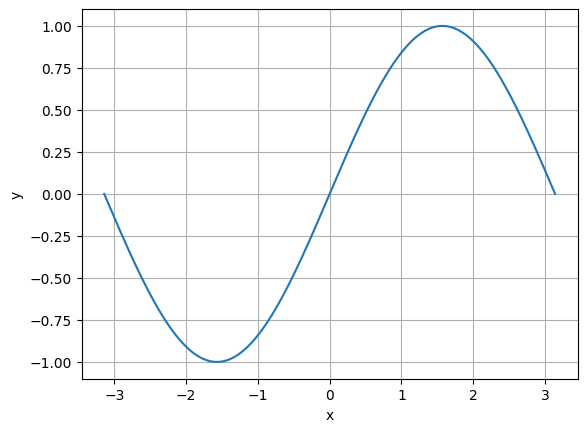

In [2]:
N = 2000 # Number of samples
x = torch.linspace(-torch.pi, torch.pi, N, dtype=torch.float32) # Creates input data, composed of equally spaced points in the range [-pi, pi)
y = torch.sin(x) # Creates output data by applying the function `sin` elementwise to `x`
plt.plot(x, y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

## Polynomial curve fitting

* Suppose that you did not know that the variables $y$ and $x$ are related by $y = \sin(x)$.

* Instead, suppose that you only have access to the pairs $(x_1, y_1), (x_2, y_2), \ldots, (x_N, y_N)$ generated above.

* In this example, we will pretend to believe that the function $f$ that generates $y$ from $x$ is a polynomial of degree $3$ given by
$$ f(x) = w_0 + w_1 x + w_2x^2 + w_3 x^3, $$
where $\mathbf{w} = [ w_0, w_1, w_2, w_3]^T$ is a vector of *unknown* parameters, which we will call *weights*.

* This exercise simulates having a *hypothesis* about the mechanism that generates the data (in this case, the hypothesis is wrong, since the sinusoidal function is not a polynomial!).

* Our goal will be to find weights $\mathbf{w} = [ w_0, w_1, w_2, w_3]^T$ that fit the data as well as possible.

Weights: tensor([ 0.4539,  1.1548, -0.2014,  0.3493])


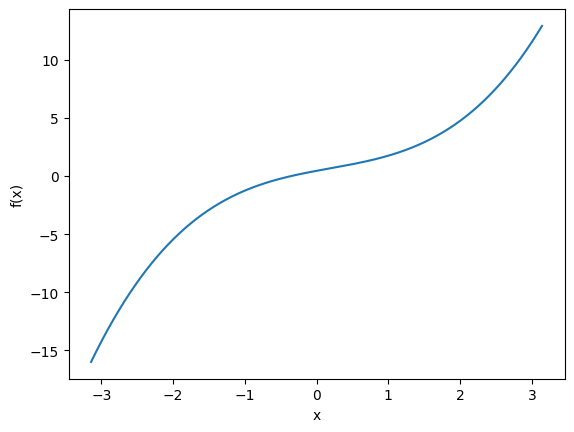

In [3]:
# Run this cell multiple times to see different degree 3 polynomials
w = torch.randn(4, dtype=torch.float32) # Randomly initializes weights

def f(x, w):
    return w[0] + (w[1] * x) + (w[2] * x**2) + (w[3] * x**3)

plt.plot(x, f(x, w)) # Applies a function elementwise to `x` and plots the result
plt.xlabel('x')
plt.ylabel('f(x)')
print(f'Weights: {w}')

## Gradients  

* Consider the pairs $(x_1, y_1), (x_2, y_2), \ldots, (x_N, y_N)$, where $y_i = \sin(x_i)$ for every $i$.

* For some weights $\mathbf{w} = [ w_0, w_1, w_2, w_3]^T$, let $\tilde{y}_i = f(x_i)$ for every $i$, where $f$ is the polynomial given by $f(x_i) = w_0 + w_1 x_i + w_2x_i^2 + w_3 x_i^3$. We will call $\tilde{y}_i$ the *prediction* for $x_i$.

* Note how the prediction $\tilde{y}_i$ depends on the weights $\mathbf{w}$.

* Our goal is to find weights that make the polynomial "as close as possible" to the function that generated the data.

* We can measure how close the function $f$ is to the (supposedly unknown) function $\sin$ based on the pairs $(x_1, y_1), (x_2, y_2), \ldots, (x_N, y_N)$ by using the squared loss $L$ given by

$$ L = \sum_{i = 1}^N (\tilde{y}_i - y_i)^2 = (\tilde{y}_1 - y_1)^2 + (\tilde{y}_2 - y_2)^2 + \cdots + (\tilde{y}_N - y_N)^2. $$

* Note how the loss $L$ depends on the weights $\mathbf{w}$ because the predictions $\tilde{y}_1, \ldots, \tilde{y}_N$ depend on $\mathbf{w}$.

* In order to find the weights that minimize this loss (make it as small as possible), we will use an algorithm called *gradient descent*, which requires computing the gradient of $L$ with respect to $\mathbf{w}$, which we will denote by $\nabla L$.

* Recall that the gradient vector $\nabla L$ (of $L$ with respect to $\mathbf{w}$) is given by
$$ \nabla L = \left[ \frac{\partial L}{ \partial w_0}, \frac{\partial L}{ \partial w_1}, \frac{\partial L}{ \partial w_2}, \frac{\partial L}{ \partial w_3} \right]^T .$$

* In the previous lab session, we found that the partial derivatives above are given by

$$ \frac{\partial L}{\partial w_0} = 2 \sum_{k = 1}^N (\tilde{y}_k - y_k),$$
$$ \frac{\partial L}{\partial w_1} = 2 \sum_{k = 1}^N (\tilde{y}_k - y_k)x_k,$$
$$ \frac{\partial L}{\partial w_2} = 2 \sum_{k = 1}^N (\tilde{y}_k - y_k)x_k^2,$$
$$ \frac{\partial L}{\partial w_3} = 2 \sum_{k = 1}^N (\tilde{y}_k - y_k)x_k^3.$$

* Suppose we organize the data into vectors $\mathbf{y} = [y_1, y_2, \ldots, y_N]^T$, $\tilde{\mathbf{y}} = [\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_N]^T$, and $\mathbf{x}^j = [x_1^j, x_2^j, \ldots, x_N^j]^T$ for every $j \in \{0, 1, 2, 3\}$. In that case,
$$ \frac{\partial L}{\partial w_j} = 2 ( \tilde{\mathbf{y}} - \mathbf{y})^T\mathbf{x}^j.$$

## Gradient descent

* Your first task in this session is to implement gradient descent, the optimization algorithm that we will use to find weights $\mathbf{w} = [ w_0, w_1, w_2, w_3]^T$ that fit the data as well as possible.

* You should implement the following algorithm:
    * Initialize the weights $\mathbf{w}$ arbitrarily.
    * Repeat the following for $2000$ iterations:
        * Compute the prediction vector $\tilde{\mathbf{y}}$ for the current weights $\mathbf{w}$.
        * Compute the gradient $\nabla L$ of the loss with respect to the weights using the equations above.
        * Multiply the resulting vector by a small positive constant (learning rate)  $\eta = 10^{-6}$ (in Python, written `1e-6`) and then subtract it from the current weights $\mathbf{w}$ to obtain new weights $\mathbf{w}$:

$$ \mathbf{w} \gets \mathbf{w} - \eta \nabla L .$$

* You should use the code below as a starting point.

In [4]:
# Fill in the gaps in the code below (see `TODO` notes)
w = torch.rand(4) # Randomly initializes weights

print(f'Initial weights: {w}')

lr = 1e-6 # Learning rate

for t in range(2000):
    y_hat = f(x, w) # Computes predictions with current weights

    loss = (y_hat - y).pow(2).sum()
    if t % 100 == 0: # Prints loss every 100 iterations
        print(f'Loss: {loss}')

    dLdw0 = 0 # TODO: Compute the partial derivative dL/dw0
    dLdw1 = 0 # TODO: Compute the partial derivative dL/dw1
    dLdw2 = 0 # TODO: Compute the partial derivative dL/dw2
    dLdw3 = 0 # TODO: Compute the partial derivative dL/dw3

    grad = torch.tensor([dLdw0, dLdw1, dLdw2, dLdw3])

    w -= torch.zeros(4) # TODO: Compute the update using in-place subtraction

print(f'Learned weights: {w}')

Initial weights: tensor([0.9243, 0.9271, 0.1631, 0.2148])
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Loss: 32623.185546875
Learned weights: tensor([0.9243, 0.9271, 0.1631, 0.2148])


Weights: tensor([0.9243, 0.9271, 0.1631, 0.2148])


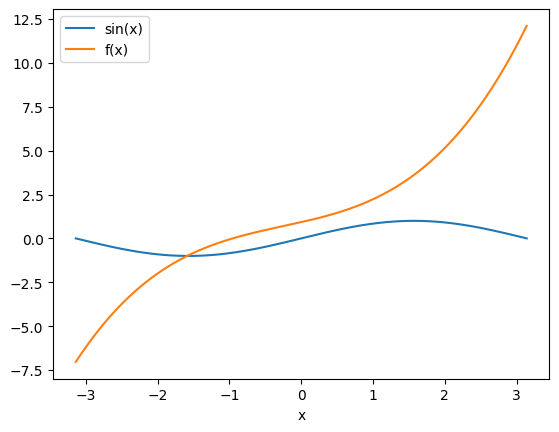

In [5]:
# Plots the original function and the learned function
plt.plot(x, torch.sin(x), label='sin(x)')
plt.plot(x, f(x, w), label='f(x)')
plt.legend(loc='best')
plt.xlabel('x')
print(f'Weights: {w}')

## Gradient Descent with Automatic Differentiation

* Your second task is to use automatic differentiation to compute the gradient $\nabla L$ for given weights $\mathbf{w}$

* You should use the code below as a starting point.

In [6]:
# Fill in the gaps in the code below (see `TODO` notes)
w = torch.rand(4, requires_grad=True) # Randomly initializes weights, and sets `requires_grad` to `True`

print(f'Initial weights: {w}')

lr = 1e-6 # Learning rate

for t in range(2000):
    y_hat = f(x, w) # Computes predictions with current weights

    loss = (y_hat - y).pow(2).sum()
    if t % 100 == 0: # Prints loss every 100 iterations
        print(f'Loss: {loss}')

    loss.backward() # Calls the method `backward` to compute and store the gradients of the loss with respect to the weights.

    # The gradients of the weight update should not be computed, so we need to use `torch.no_grad`
    with torch.no_grad():
        w -= torch.zeros(4) # TODO: Compute the update using an in-place subtraction. Recall that the gradients are stored in `w` after `backward` is called.

    # TODO: Set the gradients stored in `w` to zero. This is required because PyTorch accumulates gradients across calls to `backward` by default.

print(f'Learned weights: {w}')

Initial weights: tensor([0.9866, 0.2779, 0.5546, 0.6958], requires_grad=True)
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Loss: 159285.96875
Learned weights: tensor([0.9866, 0.2779, 0.5546, 0.6958], requires_grad=True)


Weights: tensor([0.9866, 0.2779, 0.5546, 0.6958], requires_grad=True)


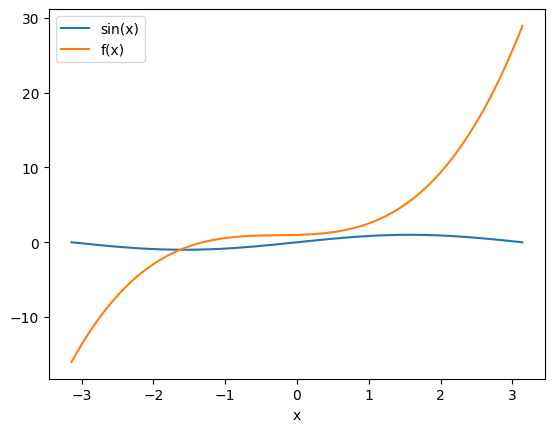

In [7]:
# Plots the original function and the learned function
plt.plot(x, torch.sin(x), label='sin(x)')
plt.plot(x, f(x, w).detach(), label='f(x)')
plt.legend(loc='best')
plt.xlabel('x')
print(f'Weights: {w}')